# Inspecting transfusion.data file

Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to WebMD, "about 5 million Americans need a blood transfusion every year".

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.

The data is stored in data/transfusion.data and it is structured according to RFMTC marketing model (a variation of RFM). First, let's inspect the data.

In [1]:
!head -n5 ../Predicting-Blood-Donations/data/transfusion.data

# Setting the environment

In [2]:
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# loading the data 

In [3]:
# we load the data into memory
transfusion = pd.read_csv("../Predicting-Blood-Donations/data/transfusion.data")
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


# Inspecting the data 

It looks like our dataset uses RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

- R (Recency - months since the last donation)
- F (Frequency - total number of donation)
- M (Monetary - total blood donated in c.c.)
- T (Time - months since the first donation)
- a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)

In [4]:
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


All of our variables are numeric with no missing values.

# Target  column and its incidence 

In [5]:
transfusion.columns 

Index(['Recency (months)', 'Frequency (times)', 'Monetary (c.c. blood)',
       'Time (months)', 'whether he/she donated blood in March 2007'],
      dtype='object')

We see that our target column is not standardly named. let's rename it as *'target'* so that it is convenient to work with, especially for TPOT kind of Algorithms. 

In [6]:
transfusion.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace= True)
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:

0. *the donor will not give blood*
1. *he donor will give blood*

Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

In [7]:
transfusion.target.value_counts(normalize=True).round(2)

0    0.76
1    0.24
Name: target, dtype: float64

target variable incidence signals that 0s occur 76% of the time. The column is quite unbalanced.

We could for example downsample it or upsample it, but since we're dealing with blood donations context we'll leave it as it is while maintaining the same distribution in our train set. we'll use stratify parameter on the target column.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(transfusion.drop(columns='target'), transfusion.target,
                                                   test_size=0.3,
                                                   random_state=42,
                                                   stratify=transfusion.target)

In [9]:
y_train.value_counts(normalize=True)

0    0.762906
1    0.237094
Name: target, dtype: float64

We're good. We managed to keep the same stratification of the classes.

# Model selection using TPOT

I decided to use TPOT for this dataset to help me zero in on one model that we can optimize further on a latter step. 

In [10]:
!pip install tpot

In [11]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

#Instantiate the TPOTClassifier
tpot = TPOTClassifier(generations=10,
                     population_size= 20,
                     verbosity=2,
                     scoring= ['roc_auc'],
                     random_state=42,
                     disable_update_check=True,
                     early_stop =5
                     )
tpot.fit(X_train,y_train)

#roc_auc score 
y_pred= tpot.predict_proba(X_test)[:,1]
roc_auc_score = roc_auc_score(y_test , y_pred)
print(f'\nAUC score: {roc_auc_score:.4f}')


# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')

/Users/oumniasadaouni/.pyenv/versions/3.8.6/envs/pix2pix/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Optimization Progress:   0%|          | 0/220 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7934981684981685

Generation 2 - Current best internal CV score: 0.7934981684981685

Generation 3 - Current best internal CV score: 0.7934981684981685

Generation 4 - Current best internal CV score: 0.7934981684981685

Generation 5 - Current best internal CV score: 0.7934981684981685

Generation 6 - Current best internal CV score: 0.7934981684981685

Generation 7 - Current best internal CV score: 0.7934981684981685

Generation 8 - Current best internal CV score: 0.7934981684981685

Generation 9 - Current best internal CV score: 0.7954212454212455

Generation 10 - Current best internal CV score: 0.7973443223443223

Best pipeline: RandomForestClassifier(LogisticRegression(MLPClassifier(MinMaxScaler(input_matrix), alpha=0.1, learning_rate_init=0.01), C=0.001, dual=False, penalty=l2), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=19, n_estimators=100)

AUC score: 0.7494

Best pipeline steps:
1. MinM

Let's visualize the ROC curve.

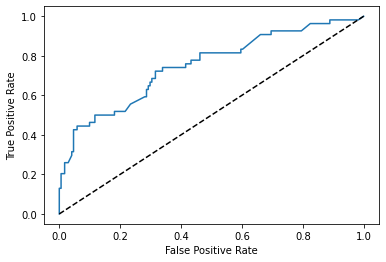

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#plotting the roc curve 
plt.plot(fpr,tpr, label="ROC curve (area = %0.2f)" %roc_auc_score.round(2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], 'k--');


letting our tpot wander in a broad range of possible ML models, the result came out to be a multilayer stacking ensemble with an MLPClassifier and LogisticRegression as estimators and RandomForestClassifier as a final estimator. This pipeline started with a preprocessing using MinMaxScaler of the data. 

Our AUC score is 75%, which is not bad at all! This score signals that there is 75% chance that the model will correctly distinguish a doner's willingness to actually give blood. 

Our last step would be to rerun a tpot but this time around using a restricted configuration of "simple" models and see if we ever manage to increase our tpr of the roc curve. 

In [18]:
#Exporting our magical tpot
tpot.export('tpot_MAGIC_blood_donations_pipeline.py')

In [13]:
#Instantiate the TPOTClassifier
tpot_light = TPOTClassifier(generations=5,
                     population_size= 20,
                     verbosity=2,
                     scoring= ['roc_auc'],
                     random_state=42,
                     disable_update_check=True,
                     early_stop =5,
                    config_dict= 'TPOT light')

tpot_light.fit(X_train,y_train)



Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7781501831501831

Generation 2 - Current best internal CV score: 0.7781501831501831

Generation 3 - Current best internal CV score: 0.7782051282051282

Generation 4 - Current best internal CV score: 0.7839377289377288

Generation 5 - Current best internal CV score: 0.7839377289377288

Best pipeline: MultinomialNB(MinMaxScaler(input_matrix), alpha=100.0, fit_prior=False)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               early_stop=5, generations=5, population_size=20, random_state=42,
               scoring=['roc_auc'], verbosity=2)

Using a TPOT light version signaled a slightly decreasing model accuracy, from 79.7% to 78.4%. 

The result invites us to customize a pipepline to solve this classification problem. 

# Customized pipeline